# temporal ranking corr and fixing moving invariants

In [1]:
import numpy as np
import torch
import sys
import os

import argparse
import numpy as np
import json

from umap.umap_ import find_ab_params
sys.path.append("..")
from singleVis.SingleVisualizationModel import SingleVisualizationModel
from singleVis.data import NormalDataProvider
import singleVis.config as config
from singleVis.eval.evaluator import Evaluator
from singleVis.projector import Projector

In [2]:
DATASET = "mnist"
CONTENT_PATH = "/home/xianglin/projects/DVI_data/resnet18_{}".format(DATASET)

In [3]:
sys.path.append(CONTENT_PATH)
from config import config

In [4]:
GPU_ID = 0
SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
S_LAMBDA = VISUALIZATION_PARAMETER["S_LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]
SEGMENTS = VISUALIZATION_PARAMETER["SEGMENTS"]
RESUME_SEG = VISUALIZATION_PARAMETER["RESUME_SEG"]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

content_path = CONTENT_PATH
sys.path.append(content_path)

import Model.model as subject_model
# net = resnet18()
net = eval("subject_model.{}()".format(NET))
classes = ("airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [5]:
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
if PREPROCESS:
    data_provider.initialize(LEN//10, l_bound=L_BOUND)

model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=HIDDEN_LAYER)
projector = Projector(vis_model=model, content_path=CONTENT_PATH, segments=SEGMENTS, device=DEVICE)

Finish initialization...


Successfully load the visualization model for range (5,20)...
Computing decision regions ...
Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 300/300 [00:00<00:00, 8507.89it/s]


Same range as current visualization model...
Same range as current visualization model...


(-11.774971, -11.774971, 12.279456, 12.279456)

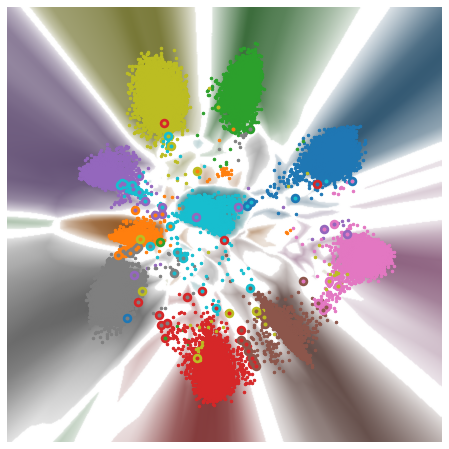

In [8]:
from singleVis.visualizer import visualizer

vis = visualizer(data_provider, projector, 500)
save_dir = os.path.join(data_provider.content_path, "img")
os.system("mkdir -p {}".format(save_dir))
vis.savefig(5)
vis.get_epoch_plot_measures(5)
# for i in range(EPOCH_START, EPOCH_END+1, EPOCH_PERIOD):
#     vis.savefig(i, path=os.path.join(save_dir, "{}_{}_tnn.png".format(DATASET, i)))

In [7]:
evaluator = Evaluator(data_provider, projector)
for eval_epoch in [4,12,20]: 
    evaluator.save_epoch_eval(eval_epoch, 15, temporal_k=5, save_corrs=False, file_name="test_evaluation_hybrid")

Successfully load the visualization model for range (1,5]...
Sun Aug 14 15:08:12 2022 Building RP forest with 17 trees
Sun Aug 14 15:08:14 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Aug 14 15:08:27 2022 Building RP forest with 17 trees
Sun Aug 14 15:08:27 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.23/15 in epoch 4
Same range as current visualization model...
Sun Aug 14 15:08:31 2022 Building RP forest with 18 trees
Sun Aug 14 15:08:31 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Aug 14 15:08:36 2022 Building RP forest with 18 trees
Sun Aug 14 15:08:37 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#test# nn preserving : 1.21/15 in epoch 4
Same range as 

100%|██████████| 300/300 [00:00<00:00, 7678.03it/s]


#train# PPR: 0.99 in epoch 4
Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 50/50 [00:00<00:00, 11803.64it/s]


#test# PPR: 0.99 in epoch 4
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Successfully load the visualization model for range (5,20]...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Temporal t

100%|██████████| 300/300 [00:00<00:00, 7959.99it/s]


#train# PPR: 1.00 in epoch 12
Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 50/50 [00:00<00:00, 12167.28it/s]


#test# PPR: 1.00 in epoch 12
Same range as current visualization model...
Successfully load the visualization model for range (1,5]...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Successfully load the visualization model for range (5,20]...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization mo

100%|██████████| 300/300 [00:00<00:00, 7744.00it/s]


#train# PPR: 1.00 in epoch 20
Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 50/50 [00:00<00:00, 12092.91it/s]


#test# PPR: 1.00 in epoch 20
Same range as current visualization model...
Successfully load the visualization model for range (1,5]...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Successfully load the visualization model for range (5,20]...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization model...
Same range as current visualization mo

: 

In [9]:
evaluator.eval_moving_invariants_train(30,50)

100%|██████████| 300/300 [00:00<00:00, 7693.76it/s]


Same range as current visualization model...
Same range as current visualization model...
Computing decision regions ...
Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 1250/1250 [00:00<00:00, 3003.52it/s]


Computing decision regions ...
Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 1250/1250 [00:00<00:00, 3010.59it/s]


Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 1250/1250 [00:00<00:00, 2793.28it/s]


(803, 804, 1132, 1133)

In [10]:
evaluator.eval_moving_invariants_test(30,50)

100%|██████████| 50/50 [00:00<00:00, 13785.26it/s]


Same range as current visualization model...
Same range as current visualization model...
Computing decision regions ...
Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 1250/1250 [00:00<00:00, 2965.93it/s]


Computing decision regions ...
Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 1250/1250 [00:00<00:00, 2908.44it/s]


Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 1250/1250 [00:00<00:00, 2955.91it/s]


(242, 306, 337, 408)

In [17]:
# evaluator.eval_fixing_invariants_train(40,50,0.1,0.1)
evaluator.eval_proj_invariants_train(20)

100%|██████████| 300/300 [00:00<00:00, 7969.21it/s]


Same range as current visualization model...
Computing decision regions ...
Same range as current visualization model...
Same range as current visualization model...


100%|██████████| 1250/1250 [00:00<00:00, 3049.77it/s]


Same range as current visualization model...


100%|██████████| 1250/1250 [00:00<00:00, 3049.69it/s]


border fixing invariants:	2169/3048
prediction fixing invariants:	56015/56952
invariants:	58184/60000


(2169, 56015, 60000)

In [16]:
evaluator.eval_fixing_invariants_test(2, 3, 1)

100%|██████████| 50/50 [00:00<00:00, 12999.95it/s]

Same range as current visualization model...
Same range as current visualization model...


(3510, 9871)

# temporal nn spearman ranking test

In [6]:
EPOCH = 200

In [8]:
all_train_repr = np.zeros((EPOCH,LEN,512))
for i in range(1,21, 1):
    all_train_repr[i-1] = data_provider.train_representation(i)

model = trainer.model

In [23]:
low_repr = np.zeros((EPOCH,LEN,2))
for e in range(EPOCH):
    low_repr[e] = model.encoder(torch.from_numpy(all_train_repr[e]).to(device=DEVICE).float()).detach().cpu().numpy()

In [24]:
from scipy import stats

In [25]:
# shape (200, 50000, 512)
epochs = [i for i in range(EPOCH)]
corrs = np.zeros((EPOCH,500))
ps = np.zeros((EPOCH,500))
for i in range(500):
    high_embeddings = all_train_repr[:,i,:].squeeze()
    low_embeddings = low_repr[:,i,:].squeeze()

    for e in epochs:
        high_dists = np.linalg.norm(high_embeddings - high_embeddings[e], axis=1)
        low_dists = np.linalg.norm(low_embeddings - low_embeddings[e], axis=1)
        corr, p = stats.spearmanr(high_dists, low_dists)
        corrs[e][i] = corr
        ps[e][i] = p


<function matplotlib.pyplot.show(close=None, block=None)>

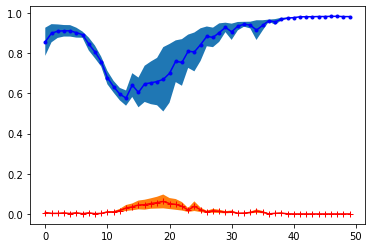

In [ ]:
import matplotlib.pyplot as plt
mean_corr = np.mean(corrs, axis=1)
var_corr = np.var(corrs, axis=1)

mean_p = np.mean(ps, axis=1)
var_p = np.var(ps, axis=1)


p1 = plt.plot(epochs, mean_corr, "b.-", epochs, mean_p, "r+-")
p2 = plt.fill_between(epochs, mean_corr-var_corr, mean_corr+var_corr)
p3 = plt.fill_between(epochs, mean_p-var_p, mean_p+var_p)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

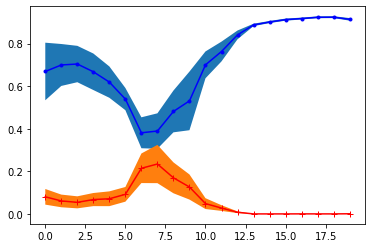

In [ ]:
import matplotlib.pyplot as plt
mean_corr = np.mean(corrs, axis=1)
var_corr = np.var(corrs, axis=1)

mean_p = np.mean(ps, axis=1)
var_p = np.var(ps, axis=1)


p1 = plt.plot(epochs, mean_corr, "b.-", epochs, mean_p, "r+-")
p2 = plt.fill_between(epochs, mean_corr-var_corr, mean_corr+var_corr)
p3 = plt.fill_between(epochs, mean_p-var_p, mean_p+var_p)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

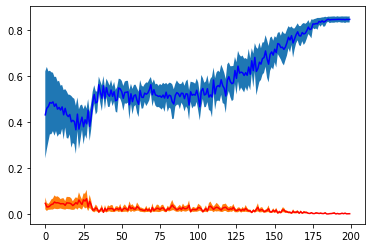

In [26]:
import matplotlib.pyplot as plt
mean_corr = np.mean(corrs, axis=1)
var_corr = np.var(corrs, axis=1)

mean_p = np.mean(ps, axis=1)
var_p = np.var(ps, axis=1)


p1 = plt.plot(epochs, mean_corr, "b-", epochs, mean_p, "r-")
p2 = plt.fill_between(epochs, mean_corr-var_corr, mean_corr+var_corr)
p3 = plt.fill_between(epochs, mean_p-var_p, mean_p+var_p)
plt.show

# fixing invarient and Moving invarient

In [27]:
from scipy.special import softmax
from scipy import stats
from scipy.spatial.distance import cosine

In [28]:
e_s = 2
e_t = 40

In [29]:
train_data_s = data_provider.train_representation(e_s)
train_data_t = data_provider.train_representation(e_t)
pred_s = data_provider.get_pred(e_s, train_data_s)
pred_t = data_provider.get_pred(e_t, train_data_t)

labels = data_provider.train_labels(20)

model = trainer.model

low_s = model.encoder(torch.from_numpy(train_data_s).to(device=DEVICE).float()).detach().cpu().numpy()
low_t = model.encoder(torch.from_numpy(train_data_t).to(device=DEVICE).float()).detach().cpu().numpy()


100%|██████████| 250/250 [00:00<00:00, 12105.19it/s]


## correlation between (kl div/js div/loss) and dists

In [9]:
def kl_div(p, q):
    return stats.entropy(p, q, base=2)


def js_div(p, q):
    M = (p+q)/2
    return .5*kl_div(p, M)+.5*kl_div(q, M)

In [15]:
# kl
softmax_s = softmax(pred_s, axis=1)
softmax_t = softmax(pred_t, axis=1)
kl_lists = [kl_div(softmax_s[i], softmax_t[i]) for i in range(len(softmax_t))]
dists = [cosine(low_t[i], low_s[i]) for i in range(len(low_s))]
corr, p = stats.spearmanr(kl_lists, dists)
corr, p

(0.5488607797007168, 0.0)

In [11]:
# js
js_lists = [js_div(softmax_s[i], softmax_t[i]) for i in range(len(softmax_t))]
dists = [cosine(low_t[i], low_s[i]) for i in range(len(low_s))]
corr, p = stats.spearmanr(js_lists, dists)
corr, p

(0.4541439913698421, 0.0)

In [12]:
# loss
loss_s = softmax_s[range(LEN), labels]
loss_t = softmax_t[range(LEN), labels]
loss_diff = np.abs(loss_s-loss_t)

dists = [cosine(low_t[i], low_s[i]) for i in range(len(low_s))]
corr, p = stats.spearmanr(js_lists, dists)
corr, p

(0.4541439913698421, 0.0)

## fixing and moving comparison

In [30]:
# normalize low dimension distance
mean_x = np.mean(low_t[:, 0])
mean_y = np.mean(low_t[:, 1])
low_t = low_t - [mean_x, mean_y]
low_s = low_s - [mean_x, mean_y]

max_n = np.linalg.norm(low_t)
low_t = low_t/max_n*100
low_s = low_s/max_n*100


In [31]:
np.linalg.norm((train_data_s-train_data_t),axis=1).mean(), np.linalg.norm((low_s-low_t),axis=1).mean()

(16.255549191454307, 0.050163385)

In [32]:
selected = np.argsort(kl_lists)
print("kl div")
print("fixing\t", np.linalg.norm((train_data_s-train_data_t)[selected[:100]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[:100]],axis=1).mean())
print("moving\t", np.linalg.norm((train_data_s-train_data_t)[selected[-100:]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[-100:]],axis=1).mean())

kl div
fixing	 15.75666724388946 0.041344266
moving	 19.623843760000035 0.3032372


In [47]:
selected = np.argsort(js_lists)
print("js div")
print("fixing\t", np.linalg.norm((train_data_s-train_data_t)[selected[:100]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[:100]],axis=1).mean())
print("moving\t", np.linalg.norm((train_data_s-train_data_t)[selected[-100:]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[-100:]],axis=1).mean())

js div
fixing	 0.2784126328281036 0.03147343
moving	 7.4485370476654165 0.4833563


In [48]:
selected = np.argsort(loss_diff)
print("loss diff")
print("fixing\t", np.linalg.norm((train_data_s-train_data_t)[selected[:100]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[:100]],axis=1).mean())
print("moving\t", np.linalg.norm((train_data_s-train_data_t)[selected[-100:]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[-100:]],axis=1).mean())

loss diff
fixing	 0.46239914135667326 0.056479488
moving	 7.489972076625427 0.5053706


## inside(outside)-class moving dists

In [28]:
p_s = pred_s.argmax(axis=1)
p_t = pred_t.argmax(axis=1)
for i in range(10):
    selected = np.logical_and(p_s==i, p_s==p_t)
    print(i, np.linalg.norm((train_data_s-train_data_t)[selected],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected],axis=1).mean())

0 2.242571759038472 0.2807122
1 1.9868760818159548 0.28744134
2 2.234642765342308 0.06597897
3 2.8872040254482236 0.27273202
4 2.044586344685677 0.32637545
5 2.11392919954649 0.12015249
6 2.0157244661746603 0.16108343
7 2.2055391471862493 0.1335515
8 1.936219060649511 0.25233826
9 1.9095602665506444 0.24290018


In [29]:
for i in range(10):
    selected = np.logical_and(p_s==i, p_s!=p_t)
    print(i, np.linalg.norm((train_data_s-train_data_t)[selected],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected],axis=1).mean())

0 5.213860885361575 0.4695684
1 4.616854768709955 0.50073403
2 4.994951531264888 0.32757828
3 4.98905760160238 0.2608999
4 5.323860879365539 0.35342965
5 5.189055546448453 0.30009905
6 5.12417897006201 0.23139767
7 5.079772257519198 0.3576349
8 5.080165057823443 0.28915018
9 4.828743283767612 0.3504236


## npr and prediction based measurements

In [32]:
from singleVis.backend import find_neighbor_preserving_rate

npr = find_neighbor_preserving_rate(train_data_s, train_data_t, 15)
selected_fix = np.logical_and(npr>0.1, p_s==p_t)
for i in range(10):
    selected = np.logical_and(selected_fix, p_s==i)
    print(i, np.linalg.norm((train_data_s-train_data_t)[selected],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected],axis=1).mean())

0 2.176139782249106 0.29397196
1 2.074862558706502 0.30089507
2 2.1669348852993267 0.06359337
3 2.573793916028262 0.27241808
4 1.8849163680567051 0.28098086
5 1.9835538611280263 0.11856113
6 1.9314286626546866 0.1589594
7 2.2124167143457223 0.1432588
8 1.9322340303954333 0.2479699
9 1.9192794587049762 0.25507292


# fixing and moving invariants

## moving

In [59]:
e_s = 1
e_t = 3

In [60]:
train_data_s = data_provider.train_representation(e_s)
train_data_t = data_provider.train_representation(e_t)
pred_s = data_provider.get_pred(e_s, train_data_s)
pred_t = data_provider.get_pred(e_t, train_data_t)

labels = data_provider.train_labels(20)

model = trainer.model

low_s = model.encoder(torch.from_numpy(train_data_s).to(device=DEVICE).float()).detach().cpu().numpy()
low_t = model.encoder(torch.from_numpy(train_data_t).to(device=DEVICE).float()).detach().cpu().numpy()

100%|██████████| 300/300 [00:00<00:00, 11495.34it/s]


In [61]:
from singleVis.utils import is_B
s_B = is_B(pred_s)
t_B = is_B(pred_t)

predictions_s = pred_s.argmax(1)
predictions_t = pred_t.argmax(1)

confident_sample = np.logical_and(np.logical_not(s_B),np.logical_not(t_B))
diff_pred = predictions_s!=predictions_t

selected = np.logical_and(diff_pred, confident_sample)


In [62]:
from singleVis.visualizer import visualizer
resolution = 500
vis = visualizer(data_provider, trainer.model, resolution, 10, classes, cmap='tab10')

In [63]:
grid_view_s, decision_view_s = vis.get_epoch_decision_view(e_s, resolution)
grid_view_t, decision_view_t = vis.get_epoch_decision_view(e_t, resolution)

grid_view_s = grid_view_s.reshape(resolution*resolution, -1)
grid_view_t = grid_view_t.reshape(resolution*resolution, -1)

grid_samples_s = trainer.model.decoder(grid_view_s).cpu().detach().numpy()
grid_samples_t = trainer.model.decoder(grid_view_t).cpu().detach().numpy()

grid_pred_s = data_provider.get_pred(e_s, grid_samples_s)+1e-8
grid_pred_t = data_provider.get_pred(e_t, grid_samples_t)+1e-8


Computing decision regions ...


100%|██████████| 1250/1250 [00:00<00:00, 2752.47it/s]


Computing decision regions ...


100%|██████████| 1250/1250 [00:00<00:00, 3518.18it/s]


In [64]:
grid_view_s = grid_view_s.cpu().detach().numpy()
grid_view_t = grid_view_t.cpu().detach().numpy()

In [65]:
grid_s_B = is_B(grid_pred_s)
grid_t_B = is_B(grid_pred_t)

grid_predictions_s = grid_pred_s.argmax(1)
grid_predictions_t = grid_pred_t.argmax(1)


In [66]:
from sklearn.neighbors import NearestNeighbors

In [67]:
high_neigh = NearestNeighbors(n_neighbors=1, radius=0.4)
high_neigh.fit(grid_view_s)
knn_dists, knn_indices = high_neigh.kneighbors(low_s, n_neighbors=1, return_distance=True)

close_s_pred = grid_predictions_s[knn_indices].squeeze()
close_s_B = grid_s_B[knn_indices].squeeze()

In [68]:
s_true = np.logical_and(close_s_pred==predictions_s, close_s_B == s_B)
np.sum(s_true[selected]), np.sum(selected)

(119, 149)

In [69]:
high_neigh = NearestNeighbors(n_neighbors=1, radius=0.4)
high_neigh.fit(grid_view_t)
knn_dists, knn_indices = high_neigh.kneighbors(low_t, n_neighbors=1, return_distance=True)

close_t_pred = grid_predictions_t[knn_indices].squeeze()
close_t_B = grid_t_B[knn_indices].squeeze()
np.sum(grid_t_B), np.sum(t_B)

(34162, 1)

In [70]:
t_true = np.logical_and(close_t_pred==predictions_t, close_t_B == t_B)
np.sum(t_true[selected]), np.sum(selected)

(148, 149)

In [71]:
np.sum(np.logical_and(s_true[selected], t_true[selected])), np.sum(selected)

(118, 149)

## fixing

In [69]:
# fixing invariants
from scipy.special import softmax
from scipy import stats
from scipy.spatial.distance import cosine

In [70]:
def kl_div(p, q):
    return stats.entropy(p, q, base=2)


def js_div(p, q):
    M = (p+q)/2
    return .5*kl_div(p, M)+.5*kl_div(q, M)

In [71]:
e_s = 1
e_t = 3

In [72]:
train_data_s = data_provider.train_representation(e_s)
train_data_t = data_provider.train_representation(e_t)
pred_s = data_provider.get_pred(e_s, train_data_s)
pred_t = data_provider.get_pred(e_t, train_data_t)
softmax_s = softmax(pred_s, axis=1)
softmax_t = softmax(pred_t, axis=1)

labels = data_provider.train_labels(20)

model = trainer.model

low_s = model.encoder(torch.from_numpy(train_data_s).to(device=DEVICE).float()).detach().cpu().numpy()
low_t = model.encoder(torch.from_numpy(train_data_t).to(device=DEVICE).float()).detach().cpu().numpy()

100%|██████████| 300/300 [00:00<00:00, 11452.44it/s]


In [73]:
# normalize low_t
y_max = max(low_s[:, 1].max(), low_t[:, 1].max())
y_min = max(low_s[:, 1].min(), low_t[:, 1].min())
x_max = max(low_s[:, 0].max(), low_t[:, 0].max())
x_min = max(low_s[:, 0].min(), low_t[:, 0].min())
scale = min(100/(x_max - x_min), 100/(y_max - y_min))
low_t = low_t*scale
low_s = low_s*scale

In [74]:
high_dists = np.linalg.norm(train_data_s-train_data_t, axis=1)
softmax_dists = np.array([js_div(softmax_s[i], softmax_t[i]) for i in range(len(softmax_t))])
euclidean_dists = np.linalg.norm(low_s-low_t, axis=1)
# cosine_dists = np.array([cosine(low_t[i], low_s[i]) for i in range(len(low_s))])

In [75]:
# find the minimum distance
from pynndescent import NNDescent
# number of trees in random projection forest
n_trees = min(64, 5 + int(round((train_data_t.shape[0]) ** 0.5 / 20.0)))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(train_data_t.shape[0]))))
# distance metric
metric = "euclidean"
# metric = "cosine"
# get nearest neighbors

nnd = NNDescent(
    train_data_t,
    n_neighbors=2,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=False
)
knn_indices, knn_dists = nnd.neighbor_graph

In [76]:
nn_ind = knn_dists[:, 1]
nn_dists = knn_dists[:, 1]

In [77]:
threshold = nn_dists.max()
threshold = 0.5
if np.sum(selected) == 0:
    print("No fixing points!")
else:
    print("euclidean dists")
    print(np.sum(euclidean_dists[selected]<low_threshold), np.sum(selected))
    print(euclidean_dists[selected].min(), euclidean_dists.min())
    print(euclidean_dists[selected].mean(), euclidean_dists.mean())
    print(euclidean_dists[selected].max(), euclidean_dists.max())

euclidean dists
1077 59952
0.014824371 0.014824371
6.395046 6.4127
69.500206 71.00036


In [78]:
softmax_diff = np.array([js_div(softmax_s[i], softmax_s[j]) for (i,j) in knn_indices])
threshold = softmax_diff.max()
selected = softmax_dists<=threshold
if np.sum(selected) == 0:
    print("No fixing points!")
else:
# selected = np.argsort(high_dists)[:100]
    print("euclidean dists")
    print(euclidean_dists[selected].min(), euclidean_dists.min())
    print(euclidean_dists[selected].mean(), euclidean_dists.mean())
    print(euclidean_dists[selected].max(), euclidean_dists.max())

euclidean dists
0.014824371 0.014824371
6.389613 6.4127
69.500206 71.00036


# Graph mutual information
**node and features**
- topology
- mutual information
>>
intrinsic dimension
softmax kl div